In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from src.data_prep.Nifty50Dataset import Nifty50Dataset
from src.forecasting.GaussianTransformer import CustomTransformerEncoderOnly
from src.forecasting.StockSeriesForcaster import StockSeriesForecaster
from src.forecasting.StockSeriesForcasterEncoder import StockSeriesForecasterEncoder

model = CustomTransformerEncoderOnly(d_model=4, nhead=2, num_encoder_layers=3, dim_feedforward=128)

dataset = Nifty50Dataset(
    "/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv",
    window_size=300,
    prediction_horizon=1
)

split_ratio = 0.1
val_size = int(len(dataset) * split_ratio)
test_size = int(len(dataset) * split_ratio)
train_size = len(dataset) - 2 * val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

forecaster = StockSeriesForecasterEncoder(model, optimizer, criterion)


[Epoch 1 | Batch 50] Loss: 0.4673
[Epoch 1 | Batch 100] Loss: 2.1217
[Epoch 1 | Batch 150] Loss: 0.4248
[Epoch 1 | Batch 200] Loss: 3.3637
[Epoch 1 | Batch 250] Loss: 1.3908
[Epoch 1 | Batch 300] Loss: 0.6345
[Epoch 1 | Batch 350] Loss: 0.2949
[Epoch 1 | Batch 400] Loss: 0.2666
[Epoch 1 | Batch 450] Loss: 0.6896
[Epoch 1 | Batch 500] Loss: 0.1934
[Epoch 1 | Batch 550] Loss: 0.0753
[Epoch 1 | Batch 600] Loss: 1.7792
[Epoch 1 | Batch 650] Loss: 1.9238
[Epoch 1 | Batch 700] Loss: 0.7469
[Epoch 1 | Batch 750] Loss: 0.2610
[Epoch 1 | Batch 800] Loss: 0.0687
[Epoch 1 | Batch 850] Loss: 3.9787
[Epoch 1 | Batch 900] Loss: 0.0061
[Epoch 1 | Batch 950] Loss: 2.2599
[Epoch 1 | Batch 1000] Loss: 0.1509
[Epoch 1 | Batch 1050] Loss: 1.1369
[Epoch 1 | Batch 1100] Loss: 4.5082
[Epoch 1 | Batch 1150] Loss: 3.2998
[Epoch 1 | Batch 1200] Loss: 0.5379
[Epoch 1 | Batch 1250] Loss: 7.0691
[Epoch 1 | Batch 1300] Loss: 0.3608
[Epoch 1 | Batch 1350] Loss: 3.4924
[Epoch 1 | Batch 1400] Loss: 1.0694
[Epoch 1 | B

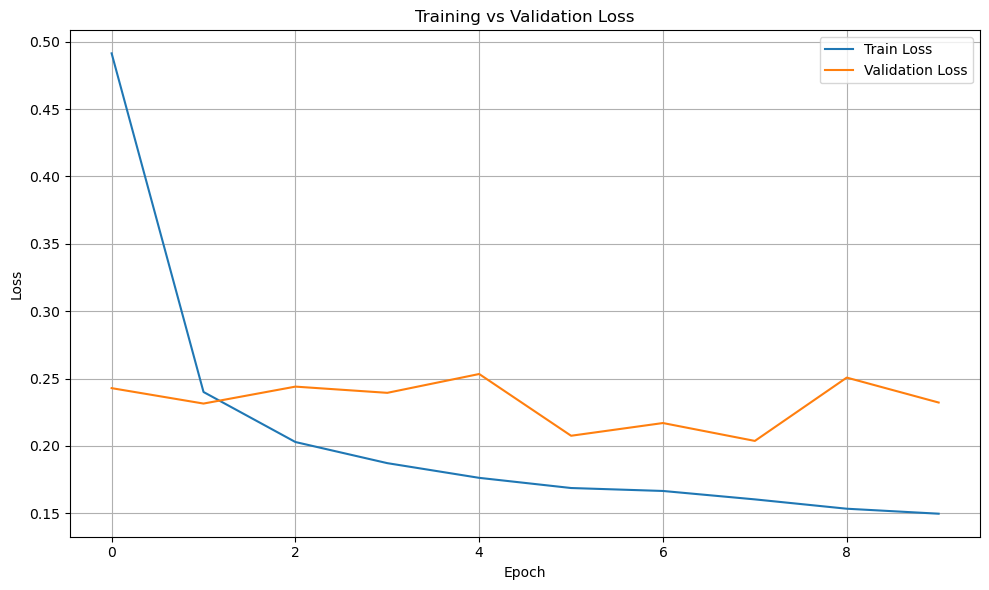

In [2]:
train_loss, val_loss = forecaster.train(train_loader, val_loader, epochs=10)

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
num_batches = 3
for i, (x, y) in enumerate(train_loader):
    if i >= num_batches:
        break
    output = forecaster.autoregressive_predict(x, max_len=20)
    print("Generated:", output)

Generated: tensor([[8457.6279, 8485.8047, 8505.7822, 8520.1572, 8533.6416, 8549.1875,
         8567.6797, 8590.0391, 8613.5449, 8637.1494, 8660.5479, 8675.6553,
         8683.1191, 8687.4268, 8690.4141, 8692.9033, 8694.7578, 8696.0586,
         8697.0127, 8697.7256],
        [8425.6953, 8423.9111, 8422.0371, 8419.8770, 8417.2969, 8413.8457,
         8409.2393, 8403.3145, 8394.5967, 8378.5371, 8352.5957, 8333.2129,
         8325.9785, 8325.6855, 8327.5566, 8330.4668, 8333.7881, 8337.1777,
         8340.3223, 8343.3770]])
Generated: tensor([[8583.6934, 8581.9580, 8579.4893, 8576.1270, 8571.7393, 8564.7637,
         8554.3398, 8544.4453, 8538.5361, 8536.1553, 8535.7354, 8536.0059,
         8536.5488, 8537.3838, 8538.4463, 8539.7275, 8541.2539, 8542.7871,
         8544.3936, 8546.0703],
        [8621.8506, 8644.7402, 8667.6826, 8685.5068, 8695.2646, 8702.2666,
         8709.3584, 8716.8887, 8722.8965, 8726.9756, 8730.1641, 8732.3945,
         8734.1133, 8735.2549, 8735.9375, 8736.3955, 873

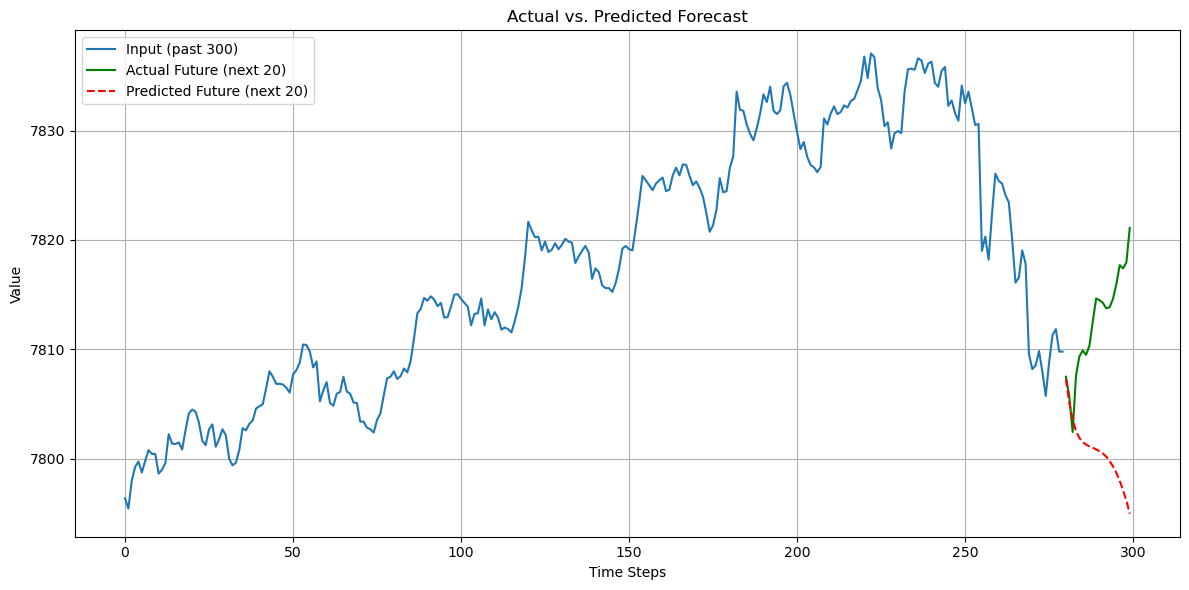

In [38]:
import matplotlib.pyplot as plt
import torch

data_x, data_y = val_dataset[200]
full_series = data_x[:320]

input_seq = full_series[:280].unsqueeze(0)
true_future = full_series[280:]

with torch.no_grad():
    predicted_future = forecaster.autoregressive_predict(input_seq, max_len=20)
predicted_future = predicted_future.squeeze().unsqueeze(-1) # Remove batch dimension

plt.figure(figsize=(12, 6))
plt.plot(range(280), input_seq.squeeze(), label='Input (past 300)')
plt.plot(range(280, 300), true_future, label='Actual Future (next 20)', color='green')
plt.plot(range(280, 300), predicted_future, label='Predicted Future (next 20)', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
torch.save(model.state_dict(), 'model_l_1.pth')

In [12]:
forecaster1 = StockSeriesForecaster(model, optimizer, criterion)
train_loss, val_loss = forecaster1.train(train_loader, val_loader)

KeyboardInterrupt: 

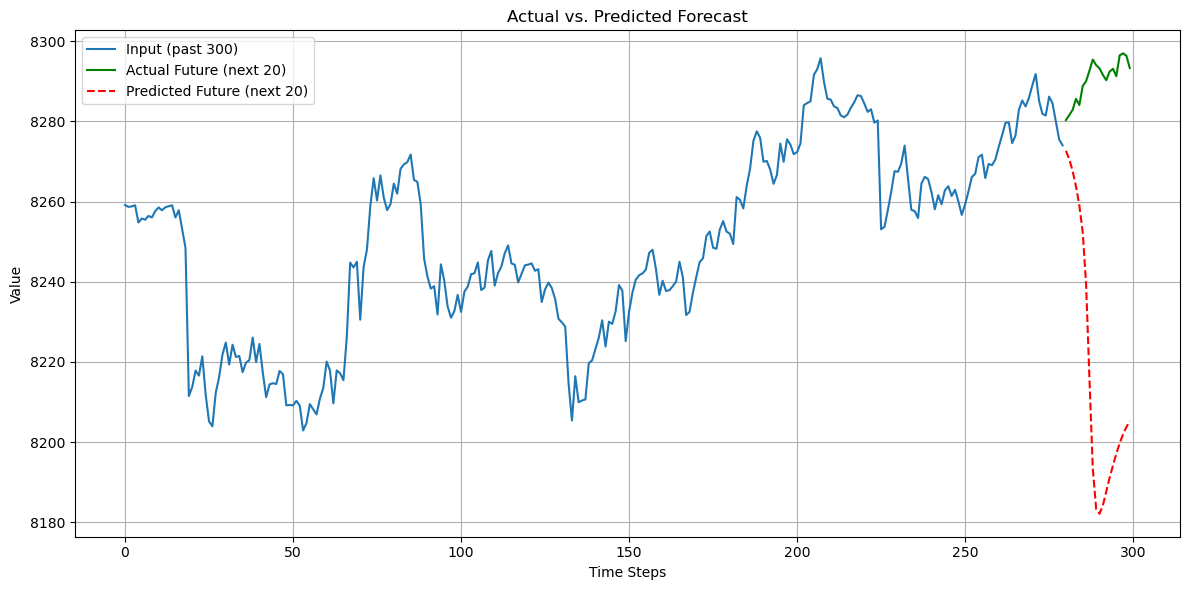